# 3D Multi-organ Segmentation with UNETR (BTCV Challenge)
Translated by: **饭饭**.

教程修改翻译自 https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d_lightning.ipynb

本教程展示了MONAI如何与PyTorch Lightning框架结合使用，利用BTCV挑战数据集构建UNETR的多器官分割任务的训练工作流程。

![image](https://lh3.googleusercontent.com/pw/AM-JKLU2eTW17rYtCmiZP3WWC-U1HCPOHwLe6pxOfJXwv2W-00aHfsNy7jeGV1dwUq0PXFOtkqasQ2Vyhcu6xkKsPzy3wx7O6yGOTJ7ZzA01S6LSh8szbjNLfpbuGgMe6ClpiS61KGvqu71xXFnNcyvJNFjN=w1448-h496-no?authuser=0)

它包含以下流程:
1. 字典格式数据的转换。
2. 根据MONAI transform API定义一个新的变换。
3. 加载Nifti图像通过元数据，加载一系列图像，并将其堆叠。
4. 随机调整强度，进行数据增强。
5. 缓存IO和转换，以加速训练和验证。
6. 三维UNETR模型，Dice损失函数，多器官分割任务的平均Dice度量。

数据集来源 https://www.synapse.org/#!Synapse:syn3193805/wiki/217752.  

在机构审查委员会（IRB）的监督下，从一个正在进行的结直肠癌化疗试验和一个回顾性的腹腔疝研究中随机选择了50张腹部CT扫描。这50张扫描是在门静脉造影阶段采集的，容积大小（512 x 512 x 85 - 512 x 512 x 198）和视野（大约280 x 280 x 280 mm3 - 500 x 500 x 650 mm3）各不相同。平面内分辨率从0.54 x 0.54 mm2到0.98 x 0.98 mm2不等，而切片厚度从2.5 mm到5.0 mm。

目标：13个腹部器官，包括：1. 脾脏 2. 右肾 3. 左肾 4.胆囊 5.食道 6. 肝脏 7. 胃 8.主动脉 9. IVC 10. 门静脉和脾静脉 11. 胰腺 12 右肾上腺 13 左肾上腺。

数据类型: CT
大小: 30 3D volumes (24 Training + 6 Testing)  
挑战: BTCV MICCAI Challenge

下图显示了在CT中被注释的器官子区域的图像斑块（左上）和整个数据集的最终标签（右）。

数据、图来自于：


1. [UNETR: Transformers for 3D Medical Image Segmentation](https://arxiv.org/abs/2103.10504)

2. [High-resolution 3D abdominal segmentation with random patch network fusion (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589)

3. [Efficient multi-atlas abdominal segmentation on clinically acquired CT with SIMPLE context learning (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841515000766?via%3Dihub)


![image](https://lh3.googleusercontent.com/pw/AM-JKLX0svvlMdcrchGAgiWWNkg40lgXYjSHsAAuRc5Frakmz2pWzSzf87JQCRgYpqFR0qAjJWPzMQLc_mmvzNjfF9QWl_1OHZ8j4c9qrbR6zQaDJWaCLArRFh0uPvk97qAa11HtYbD6HpJ-wwTCUsaPcYvM=w1724-h522-no?authuser=0)



图像斑块显示了一个主体的解剖结构，包括：
1. 大器官：脾、肝、胃。 
2. 较小的器官：胆囊、食道、肾脏、胰腺。
3. 血管组织：主动脉、IVC、P&S静脉。 
4. 腺体：左、右肾上腺

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d_lightning.ipynb)

In [5]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    list_data_collate,
)

import torch
import pytorch_lightning
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print_config()

MONAI version: 1.0.0
Numpy version: 1.22.4
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 170093375ce29267e45681fcec09dfa856e1d7e7
MONAI __file__: d:\anaconda\envs\pytorch\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.18.3
Pillow version: 9.2.0
Tensorboard version: 2.8.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0+cu113
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.5
einops version: 0.3.2
transformers version: 4.12.5
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencie

In [25]:
import monai
from monai.data import ImageDataset, create_test_image_3d, decollate_batch, DataLoader
from monai.transforms import Activations, EnsureChannelFirst, AsDiscrete, Compose, RandRotate90, RandSpatialCrop, ScaleIntensity


import nibabel as nib
import numpy as np

from glob import glob
import os

import matplotlib.pyplot as plt

In [22]:
tempdir = 'tempdataset'
if not os.path.exists(tempdir):
    os.makedirs(tempdir, exist_ok=True)

In [18]:
# create a temporary directory and 40 random image, mask pairs
print(f"generating synthetic data to {tempdir} (this may take a while)")
for i in range(40):
    im, seg = create_test_image_3d(128, 128, 128, num_seg_classes=2)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(tempdir, f"im{i:d}.nii.gz"))

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(tempdir, f"seg{i:d}.nii.gz"))

images = sorted(glob(os.path.join(tempdir, "im*.nii.gz")))
segs = sorted(glob(os.path.join(tempdir, "seg*.nii.gz")))

generating synthetic data to tempdataset (this may take a while)


In [15]:
images

['tempdataset\\im0.nii.gz',
 'tempdataset\\im1.nii.gz',
 'tempdataset\\im10.nii.gz',
 'tempdataset\\im11.nii.gz',
 'tempdataset\\im12.nii.gz',
 'tempdataset\\im13.nii.gz',
 'tempdataset\\im14.nii.gz',
 'tempdataset\\im15.nii.gz',
 'tempdataset\\im16.nii.gz',
 'tempdataset\\im17.nii.gz',
 'tempdataset\\im18.nii.gz',
 'tempdataset\\im19.nii.gz',
 'tempdataset\\im2.nii.gz',
 'tempdataset\\im20.nii.gz',
 'tempdataset\\im21.nii.gz',
 'tempdataset\\im22.nii.gz',
 'tempdataset\\im23.nii.gz',
 'tempdataset\\im24.nii.gz',
 'tempdataset\\im25.nii.gz',
 'tempdataset\\im26.nii.gz',
 'tempdataset\\im27.nii.gz',
 'tempdataset\\im28.nii.gz',
 'tempdataset\\im29.nii.gz',
 'tempdataset\\im3.nii.gz',
 'tempdataset\\im30.nii.gz',
 'tempdataset\\im31.nii.gz',
 'tempdataset\\im32.nii.gz',
 'tempdataset\\im33.nii.gz',
 'tempdataset\\im34.nii.gz',
 'tempdataset\\im35.nii.gz',
 'tempdataset\\im36.nii.gz',
 'tempdataset\\im37.nii.gz',
 'tempdataset\\im38.nii.gz',
 'tempdataset\\im39.nii.gz',
 'tempdataset\\im4

In [17]:
segs

['tempdataset\\seg0.nii.gz',
 'tempdataset\\seg1.nii.gz',
 'tempdataset\\seg10.nii.gz',
 'tempdataset\\seg11.nii.gz',
 'tempdataset\\seg12.nii.gz',
 'tempdataset\\seg13.nii.gz',
 'tempdataset\\seg14.nii.gz',
 'tempdataset\\seg15.nii.gz',
 'tempdataset\\seg16.nii.gz',
 'tempdataset\\seg17.nii.gz',
 'tempdataset\\seg18.nii.gz',
 'tempdataset\\seg19.nii.gz',
 'tempdataset\\seg2.nii.gz',
 'tempdataset\\seg20.nii.gz',
 'tempdataset\\seg21.nii.gz',
 'tempdataset\\seg22.nii.gz',
 'tempdataset\\seg23.nii.gz',
 'tempdataset\\seg24.nii.gz',
 'tempdataset\\seg25.nii.gz',
 'tempdataset\\seg26.nii.gz',
 'tempdataset\\seg27.nii.gz',
 'tempdataset\\seg28.nii.gz',
 'tempdataset\\seg29.nii.gz',
 'tempdataset\\seg3.nii.gz',
 'tempdataset\\seg30.nii.gz',
 'tempdataset\\seg31.nii.gz',
 'tempdataset\\seg32.nii.gz',
 'tempdataset\\seg33.nii.gz',
 'tempdataset\\seg34.nii.gz',
 'tempdataset\\seg35.nii.gz',
 'tempdataset\\seg36.nii.gz',
 'tempdataset\\seg37.nii.gz',
 'tempdataset\\seg38.nii.gz',
 'tempdataset\

In [23]:
# define transforms for image and segmentation
train_imtrans = Compose(
    [
        ScaleIntensity(),
        EnsureChannelFirst(),
        RandSpatialCrop((96, 96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 2)),
    ]
)
train_segtrans = Compose(
    [
        EnsureChannelFirst(),
        RandSpatialCrop((96, 96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 2)),
    ]
)

In [24]:
# define image dataset, data loader
check_ds = ImageDataset(images, segs, transform=train_imtrans, seg_transform=train_segtrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg = monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

(10, 1, 96, 96, 96) (10, 1, 96, 96, 96)


In [35]:
len(check_loader)

4

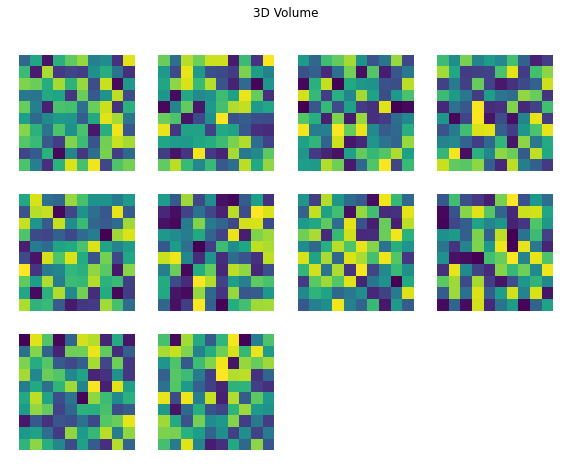

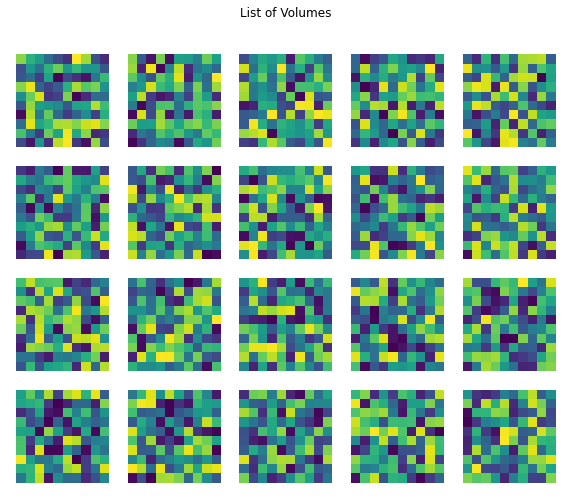

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from monai.visualize import matshow3d
# create a figure of a 3D volume
volume = np.random.rand(10, 10, 10)
fig = plt.figure()
matshow3d(volume, fig=fig, title="3D Volume")
plt.show()
# create a figure of a list of channel-first 3D volumes
volumes = [np.random.rand(1, 10, 10, 10), np.random.rand(1, 10, 10, 10)]
fig = plt.figure()
matshow3d(volumes, fig=fig, title="List of Volumes")
plt.show()

In [3]:
# densenet 3d
import torch
from monai.networks.nets import DenseNet
from monai.visualize import OcclusionSensitivity

model_3d = DenseNet(spatial_dims=3, in_channels=1, out_channels=3, init_features=2, growth_rate=2, block_config=(6,))
occ_sens = OcclusionSensitivity(nn_module=model_3d, n_batch=10, stride=3)
occ_map, most_probable_class = occ_sens(torch.rand(1, 1, 6, 6, 6), b_box=[-1, -1, 1, 3, -1, -1, -1, -1])

Computing occlusion sensitivity: 100%|██████████| 4/4 [00:00<00:00, 802.16it/s]
